In [8]:
import math
import gradio
import os
import numpy as np
import functools
import trimesh
import copy
from scipy.spatial.transform import Rotation
import tempfile
import shutil
import torch
from PIL import Image
from PIL.ImageOps import exif_transpose

import cv2
import os


from mast3r.cloud_opt.sparse_ga import sparse_global_alignment
from mast3r.cloud_opt.tsdf_optimizer import TSDFPostProcess
from mast3r.image_pairs import make_pairs
from mast3r.retrieval.processor import Retriever

import mast3r.utils.path_to_dust3r  # noqa
from dust3r.utils.image import load_images
from dust3r.utils.device import to_numpy
from dust3r.viz import add_scene_cam, CAM_COLORS, OPENGL, pts3d_to_trimesh, cat_meshes
from dust3r.demo import get_args_parser as dust3r_get_args_parser

import matplotlib.pyplot as pl

In [9]:
import os
import torch
import tempfile
from contextlib import nullcontext

from mast3r.demo import get_args_parser, main_demo

from mast3r.model import AsymmetricMASt3R
from mast3r.utils.misc import hash_md5

import mast3r.utils.path_to_dust3r  # noqa
from dust3r.demo import set_print_with_timestamp

import matplotlib.pyplot as pl

In [10]:
class SparseGAState:
    def __init__(self, sparse_ga, should_delete=False, cache_dir=None, outfile_name=None):
        self.sparse_ga = sparse_ga
        self.cache_dir = cache_dir
        self.outfile_name = outfile_name
        self.should_delete = should_delete

    def __del__(self):
        if not self.should_delete:
            return
        if self.cache_dir is not None and os.path.isdir(self.cache_dir):
            shutil.rmtree(self.cache_dir)
        self.cache_dir = None
        if self.outfile_name is not None and os.path.isfile(self.outfile_name):
            os.remove(self.outfile_name)
        self.outfile_name = None

In [11]:
import PIL
import torchvision.transforms as tvf

ImgNorm = tvf.Compose([tvf.ToTensor(), tvf.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def _resize_pil_image(img, long_edge_size):
    S = max(img.size)
    if S > long_edge_size:
        interp = PIL.Image.LANCZOS
    elif S <= long_edge_size:
        interp = PIL.Image.BICUBIC
    new_size = tuple(int(round(x*long_edge_size/S)) for x in img.size)
    return img.resize(new_size, interp)

def load_video_as_frames(video_path, load_frequency=1, max_n_frames=np.inf):
    """
    Load an RGB video as a set of frames.

    Args:
        video_path (str): Path to the video file.
        size (tuple): Desired size of the frames (width, height).
        verbose (bool): Whether to print progress.

    Returns:
        list: A list of frames (each frame is a numpy array).
    """
    frames = []
    files = []
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise ValueError(f"Cannot open video file: {video_path}")

    frame_idx = 0
    while True:
        ret, frame = cap.read()
        
        if not ret:
            break
        
        if frame_idx % load_frequency != 0:
            frame_idx += 1
            continue
        frame_idx += 1
        

        # # Resize frame to the desired size
        # frame = cv2.resize(frame, size)

        # Convert BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        pil_image = Image.fromarray(frame)
        
        img = exif_transpose(pil_image).convert('RGB')
        
        W1, H1 = img.size
        
        img = _resize_pil_image(img, round(224 * max(W1/H1, H1/W1)))
        
        W, H = img.size
        cx, cy = W//2, H//2
        half = min(cx, cy)
        img = img.crop((cx-half, cy-half, cx+half, cy+half))
        
        W2, H2 = img.size

        frames.append(dict(img=ImgNorm(img)[None], true_shape=np.int32(
            [img.size[::-1]]), idx=len(frames), instance=str(len(frames))))
        
        fname = f"{frame_idx:04d}.jpg"
        os.makedirs("input_data", exist_ok=True)
        pil_image.save(os.path.join("input_data",fname))
        files.append(fname)
        
        if len(frames) >= max_n_frames:
            break

    cap.release()
    return frames, files

In [12]:
# Variables

# Scene graph definition
# This is where we define how image pairs are connected

device = "cuda"
# schedule = "cosine"
# lr = 0.01
# niter = 300

model_name = "naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric"
# you can put the path to a local checkpoint in model_name if needed
model = AsymmetricMASt3R.from_pretrained(model_name).to(device)


# filelist = [x for x in os.listdir("/scratch/toskov/data/scannetpp_working/0a76e06478/dslr/nerfstudio/") if x.endswith(".jpg")]


In [13]:
# scene_graph_params = [scenegraph_type]
# if scenegraph_type in ["swin", "logwin"]:
#     scene_graph_params.append(str(winsize))
# elif scenegraph_type == "oneref":
#     scene_graph_params.append(str(refid))
# elif scenegraph_type == "retrieval":
#     scene_graph_params.append(str(winsize))  # Na
#     scene_graph_params.append(str(refid))  # k
# if scenegraph_type in ["swin", "logwin"] and not win_cyclic:
#     scene_graph_params.append('noncyclic')
# scene_graph = '-'.join(scene_graph_params)

# scene_graph = "swin-1-noncyclic"
scene_graph = "swin-10-noncyclic"
# scene_graph = "complete"

In [14]:
# imgs = load_images(filelist, size=224, verbose=True)
# if len(imgs) == 1:
#     imgs = [imgs[0], copy.deepcopy(imgs[0])]
#     imgs[1]['idx'] = 1
#     filelist = [filelist[0], filelist[0] + '_2']

# imgs, filelist = load_video_as_frames("/scratch/toskov/data/scannetpp_working/0a76e06478/iphone/rgb.mp4", load_frequency=30, max_n_frames=40)
imgs, filelist = load_video_as_frames("/home/toskov/gen_test_vid.mp4", load_frequency=2, max_n_frames=80)

In [15]:
len(imgs)

80

In [16]:
imgs[0]["img"].shape

torch.Size([1, 3, 224, 224])

In [17]:
pairs = make_pairs(imgs, scene_graph=scene_graph, prefilter=None, symmetrize=True, sim_mat=None)

In [18]:
pairs_ids = [f"{p[0]['instance']}, {p[1]['instance']}" for p in pairs]

print(len(pairs), len(pairs_ids))
print(len(set(pairs_ids)))

pairs_ids

1490 1490
1490


['15, 21',
 '55, 57',
 '7, 17',
 '47, 53',
 '26, 30',
 '67, 68',
 '18, 26',
 '59, 64',
 '67, 77',
 '70, 73',
 '29, 32',
 '8, 9',
 '0, 5',
 '40, 41',
 '8, 18',
 '48, 54',
 '11, 14',
 '40, 50',
 '41, 42',
 '33, 38',
 '73, 74',
 '41, 51',
 '25, 34',
 '44, 47',
 '3, 6',
 '14, 15',
 '22, 28',
 '14, 24',
 '74, 75',
 '66, 71',
 '15, 16',
 '7, 12',
 '47, 48',
 '15, 25',
 '55, 61',
 '18, 21',
 '47, 57',
 '59, 68',
 '70, 77',
 '29, 36',
 '48, 49',
 '0, 9',
 '40, 45',
 '48, 58',
 '62, 69',
 '25, 29',
 '33, 42',
 '73, 78',
 '44, 51',
 '3, 10',
 '22, 23',
 '51, 59',
 '14, 19',
 '22, 32',
 '74, 79',
 '66, 75',
 '36, 43',
 '55, 56',
 '7, 16',
 '47, 52',
 '55, 65',
 '59, 63',
 '29, 31',
 '58, 67',
 '21, 27',
 '69, 76',
 '48, 53',
 '40, 49',
 '10, 17',
 '62, 64',
 '54, 60',
 '33, 37',
 '25, 33',
 '3, 5',
 '32, 41',
 '51, 54',
 '43, 50',
 '22, 27',
 '14, 23',
 '66, 70',
 '17, 25',
 '36, 38',
 '65, 74',
 '28, 34',
 '7, 11',
 '55, 60',
 '47, 56',
 '6, 15',
 '58, 62',
 '21, 22',
 '50, 58',
 '29, 35',
 '69,

In [19]:
outdir = "./outputs"
os.makedirs(outdir, exist_ok=True)

scene = sparse_global_alignment(filelist, pairs, outdir, model, device=device)

  0%|          | 0/1490 [00:00<?, ?it/s]/home/toskov/perspective-analysis-of-generated-images/mast3r/mast3r/cloud_opt/sparse_ga.py:620: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
 50%|█████     | 745/1490 [02:05<02:33,  4.84it/s]/home/toskov/perspective-analysis-of-generated-images/mast3r/mast3r/cloud_opt/sparse_ga.py:577: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be

init focals = [237.8324  231.64427 229.80313 237.20529 228.2971  228.33174 227.28099
 220.38672 237.8366  236.12723 232.5336  243.63757 239.70116 233.30804
 249.88072 238.81744 250.68976 262.91086 255.82246 265.78186 242.4157
 253.27536 248.42784 265.55472 260.3252  256.8923  257.89456 255.16544
 239.91193 226.22073 235.06828 226.7964  224.38654 221.03787 223.66762
 231.02544 231.04526 224.13159 234.43594 232.21791 235.78732 238.60095
 232.87825 229.66927 238.19807 248.17827 240.52255 248.80412 254.41423
 289.84473 274.69388 274.02118 283.39563 256.9913  245.54657 276.61295
 244.94713 249.21458 291.59015 328.37402 329.4815  316.73053 337.18332
 315.88214 383.35126 363.9082  362.81714 468.5686  440.21222 376.62238
 342.692   395.65787 484.77982 457.72885 540.72565 511.9912  527.5038
 456.10852 339.67203 365.0633 ]


100%|██████████| 300/300 [02:27<00:00,  2.03it/s, lr=0.0000, loss=0.237]


>> final loss = 0.23710377514362335


100%|██████████| 300/300 [03:01<00:00,  1.65it/s, lr=0.0000, loss=0.486]


>> final loss = 0.4861879348754883
Final focals = [251.8987  248.81848 245.46077 245.5844  245.94453 244.06851 244.34286
 243.62886 243.01334 243.23535 243.56706 243.85132 245.28456 248.65492
 246.73871 246.64436 247.20317 249.73897 249.8047  251.70802 251.8336
 251.0467  251.00769 247.1129  244.8933  242.21278 241.86806 242.5984
 242.15689 240.63187 238.79945 238.97147 240.17702 241.03404 242.42633
 241.64418 240.67514 240.24367 237.92563 236.38745 235.87076 234.66768
 236.18825 238.55692 241.63405 242.09688 242.99214 243.45142 245.58662
 247.35445 245.83994 249.30458 247.75047 249.2223  249.45119 247.1024
 247.41496 254.35469 258.90823 255.78854 266.51184 273.53687 279.7212
 282.59204 287.06647 397.29337 425.1559  665.4525  586.59875 363.0861
 335.85385 398.99786 514.97125 510.55405 555.8074  577.03094 602.0701
 622.66144 470.6877  501.69952]


In [20]:
scene.canonical_paths

["./outputs/canon_views/71d5039cf1209140b9105a4696b0b155_subsample=8_kw={'mode': 'avg-angle'}.pth",
 "./outputs/canon_views/0c2bd9aed8eeb3436b7cf20de8ee9c0c_subsample=8_kw={'mode': 'avg-angle'}.pth",
 "./outputs/canon_views/ebe357d4f8d0ba962ca883e047ecda90_subsample=8_kw={'mode': 'avg-angle'}.pth",
 "./outputs/canon_views/2d0c100cbbebbe710f9b2b4ee9130762_subsample=8_kw={'mode': 'avg-angle'}.pth",
 "./outputs/canon_views/81d31df8a58d41e2ae29679eaaba6f6f_subsample=8_kw={'mode': 'avg-angle'}.pth",
 "./outputs/canon_views/bd220e96119f11ccc92096940b1946ae_subsample=8_kw={'mode': 'avg-angle'}.pth",
 "./outputs/canon_views/4eb5772ab5ef3b695c2db5e5fff70f53_subsample=8_kw={'mode': 'avg-angle'}.pth",
 "./outputs/canon_views/38697a7fdd0ed4143df80dc5c49bfd67_subsample=8_kw={'mode': 'avg-angle'}.pth",
 "./outputs/canon_views/92f70b4c6bcf0d19a93d7a82048bb8e6_subsample=8_kw={'mode': 'avg-angle'}.pth",
 "./outputs/canon_views/a2c92c7f7d25471fe1dff2f31725fdbe_subsample=8_kw={'mode': 'avg-angle'}.pth",


In [21]:
def _convert_scene_output_to_glb(outfile, imgs, pts3d, mask, focals, cams2world, cam_size=0.05,
                                 cam_color=None, as_pointcloud=False,
                                 transparent_cams=False, silent=False):
    assert len(pts3d) == len(mask) <= len(imgs) <= len(cams2world) == len(focals)
    pts3d = to_numpy(pts3d)
    imgs = to_numpy(imgs)
    focals = to_numpy(focals)
    cams2world = to_numpy(cams2world)

    scene = trimesh.Scene()

    # full pointcloud
    if as_pointcloud:
        pts = np.concatenate([p[m.ravel()] for p, m in zip(pts3d, mask)]).reshape(-1, 3)
        col = np.concatenate([p[m] for p, m in zip(imgs, mask)]).reshape(-1, 3)
        valid_msk = np.isfinite(pts.sum(axis=1))
        pct = trimesh.PointCloud(pts[valid_msk], colors=col[valid_msk])
        scene.add_geometry(pct)
    else:
        meshes = []
        for i in range(len(imgs)):
            pts3d_i = pts3d[i].reshape(imgs[i].shape)
            msk_i = mask[i] & np.isfinite(pts3d_i.sum(axis=-1))
            meshes.append(pts3d_to_trimesh(imgs[i], pts3d_i, msk_i))
        mesh = trimesh.Trimesh(**cat_meshes(meshes))
        scene.add_geometry(mesh)

    # add each camera
    for i, pose_c2w in enumerate(cams2world):
        if isinstance(cam_color, list):
            camera_edge_color = cam_color[i]
        else:
            camera_edge_color = cam_color or CAM_COLORS[i % len(CAM_COLORS)]
        add_scene_cam(scene, pose_c2w, camera_edge_color,
                      None if transparent_cams else imgs[i], focals[i],
                      imsize=imgs[i].shape[1::-1], screen_width=cam_size)

    rot = np.eye(4)
    rot[:3, :3] = Rotation.from_euler('y', np.deg2rad(180)).as_matrix()
    scene.apply_transform(np.linalg.inv(cams2world[0] @ OPENGL @ rot))
    if not silent:
        print('(exporting 3D scene to', outfile, ')')
    scene.export(file_obj=outfile)
    return outfile


def get_3D_model_from_scene(silent, scene_state, min_conf_thr=2, as_pointcloud=False, mask_sky=False,
                            clean_depth=False, transparent_cams=False, cam_size=0.05, TSDF_thresh=0):
    """
    extract 3D_model (glb file) from a reconstructed scene
    """
    if scene_state is None:
        return None
    outfile = scene_state.outfile_name
    if outfile is None:
        return None

    # get optimized values from scene
    scene = scene_state.sparse_ga
    rgbimg = scene.imgs
    focals = scene.get_focals().cpu()
    cams2world = scene.get_im_poses().cpu()

    # 3D pointcloud from depthmap, poses and intrinsics
    if TSDF_thresh > 0:
        tsdf = TSDFPostProcess(scene, TSDF_thresh=TSDF_thresh)
        pts3d, _, confs = to_numpy(tsdf.get_dense_pts3d(clean_depth=clean_depth))
    else:
        pts3d, _, confs = to_numpy(scene.get_dense_pts3d(clean_depth=clean_depth))
    msk = to_numpy([c > min_conf_thr for c in confs])
    return _convert_scene_output_to_glb(outfile, rgbimg, pts3d, msk, focals, cams2world, as_pointcloud=as_pointcloud,
                                        transparent_cams=transparent_cams, cam_size=cam_size, silent=silent)


In [22]:
scene_state = SparseGAState(scene, False, outdir, os.path.join(outdir, "scene.glb"))
outfile = get_3D_model_from_scene(False, scene_state)

/home/toskov/perspective-analysis-of-generated-images/mast3r/mast3r/cloud_opt/sparse_ga.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  (canon, canon2, conf), focal = t

(exporting 3D scene to ./outputs/scene.glb )


In [23]:
import trimesh

mesh = trimesh.load(outfile)

In [24]:
# mesh.show()

In [25]:
# x = torch.load("/home/toskov/perspective-analysis-of-generated-images/feature_extraction/outputs/canon_views/0ef249d30e27a6625eac766c18948608_subsample=8_kw={'mode': 'avg-angle'}.pth")


In [26]:
# print(x[0][2].shape)

In [27]:
scene_state.sparse_ga.get_im_poses().cpu()[0]

tensor([[  0.8366,  -0.4510,   0.3106,  -1.7062],
        [ -0.3800,  -0.0699,   0.9228, -10.0958],
        [ -0.3934,  -0.8908,  -0.2296,  -0.3703],
        [  0.0000,   0.0000,   0.0000,   1.0000]])

In [28]:
scene_state.sparse_ga.get_sparse_pts3d()[0].shape

torch.Size([19665, 3])

In [29]:
224**2

50176

In [30]:
from mast3r.utils.misc import hash_md5

files = os.listdir("/home/toskov/perspective-analysis-of-generated-images/feature_extraction/input_data")
files = sorted(files)
files_hashed = [hash_md5(x) for x in files]

pairs_list = [f"{f}: {h}" for f,h in zip(files, files_hashed)]

pairs_list
    

['0001.jpg: 71d5039cf1209140b9105a4696b0b155',
 '0003.jpg: 0c2bd9aed8eeb3436b7cf20de8ee9c0c',
 '0005.jpg: ebe357d4f8d0ba962ca883e047ecda90',
 '0007.jpg: 2d0c100cbbebbe710f9b2b4ee9130762',
 '0009.jpg: 81d31df8a58d41e2ae29679eaaba6f6f',
 '0011.jpg: bd220e96119f11ccc92096940b1946ae',
 '0013.jpg: 4eb5772ab5ef3b695c2db5e5fff70f53',
 '0015.jpg: 38697a7fdd0ed4143df80dc5c49bfd67',
 '0017.jpg: 92f70b4c6bcf0d19a93d7a82048bb8e6',
 '0019.jpg: a2c92c7f7d25471fe1dff2f31725fdbe',
 '0021.jpg: 89920c640d06ccc3ddd203e5ba68937b',
 '0023.jpg: adadbe7e707e0a6841fe240eb58d26c4',
 '0025.jpg: 561441a27f0d88ad2ef11bfa116b5366',
 '0027.jpg: a8b959ebbefe1c53aebcc2a52ad51a92',
 '0029.jpg: 85428a417b8b6b1a40d27602c44fa9e4',
 '0031.jpg: c3c4a3373f135ab5499021f62052cb8d',
 '0033.jpg: 9f7deaff6569ae473bf8c1724c3b30e0',
 '0035.jpg: b3265d259bf3456aadd616252a1ae8f0',
 '0037.jpg: e517f03d65f2778f742e2a8a693b1972',
 '0039.jpg: a0f07522a784d839c375e90529384836',
 '0041.jpg: 915d82a5aa6890a726f7aba4daabf9d9',
 '0043.jpg: 0

In [31]:
idx1 = 55
idx2 = 56

In [32]:
first_img_hash = hash_md5(files[idx1])
second_img_hash = hash_md5(files[idx2])

In [33]:
corres_conf_fwd = f"corres_conf=desc_conf_subsample=8/{first_img_hash}-{second_img_hash}.pth"
score, (xy1, xy2, confs) = torch.load(f"/home/toskov/perspective-analysis-of-generated-images/feature_extraction/outputs/{corres_conf_fwd}")

print(xy1.shape)
xy1

torch.Size([2289, 2])


/tmp/ipykernel_6257/1748695270.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  score, (xy1, xy2, confs) = torch.load(f"/home/toskov/perspective-analysis-of-generated-ima

tensor([[196,   9],
        [197,   9],
        [214,   9],
        ...,
        [187, 218],
        [171, 219],
        [130, 220]], device='cuda:0')

In [34]:
corres_conf_bwd = f"corres_conf=desc_conf_subsample=8/{second_img_hash}-{first_img_hash}.pth"
score, (xy1, xy2, confs) = torch.load(f"/home/toskov/perspective-analysis-of-generated-images/feature_extraction/outputs/{corres_conf_bwd}")

print(xy2.shape)
xy2

torch.Size([2289, 2])


/tmp/ipykernel_6257/873892589.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  score, (xy1, xy2, confs) = torch.load(f"/home/toskov/perspective-analysis-of-generated-imag

tensor([[196,   9],
        [197,   9],
        [214,   9],
        ...,
        [187, 218],
        [171, 219],
        [130, 220]], device='cuda:0')

In [35]:
confs

tensor([4.3242, 4.3015, 3.6215,  ..., 3.8841, 7.9864, 3.0074], device='cuda:0')

In [36]:
# canon_view_root = "/home/toskov/perspective-analysis-of-generated-images/feature_extraction/outputs/canon_views"
# canon_view_paths = os.listdir(canon_view_root)

# canon_path_suffix = "_subsample=8_kw={'mode': 'avg-angle'}.pth"

# first_canon_view = f"{first_img_hash}{canon_path_suffix}"
# second_canon_view = f"{second_img_hash}{canon_path_suffix}"

# first_canon_view_path = os.path.join(canon_view_root, first_canon_view)
# second_canon_view_path = os.path.join(canon_view_root, second_canon_view)

# first_img = torch.load(first_canon_view_path)
# second_img = torch.load(second_canon_view_path)

# first_img[0][0].min()


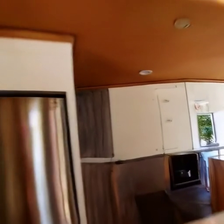

In [37]:
from PIL import Image

np_data = scene_state.sparse_ga.imgs[idx1]
Image.fromarray((np_data*255).astype(np.uint8))

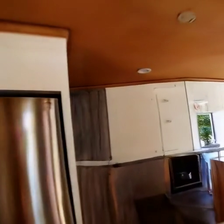

In [38]:
np_data = scene_state.sparse_ga.imgs[idx2]
Image.fromarray((np_data*255).astype(np.uint8))

In [39]:
H0, W0 = (224, 224)
H1, W1 = (224, 224)

corres_conf_fwd = f"corres_conf=desc_conf_subsample=8/{first_img_hash}-{second_img_hash}.pth"
score, (xy1, xy2, confs) = torch.load(f"/home/toskov/perspective-analysis-of-generated-images/feature_extraction/outputs/{corres_conf_fwd}")


valid_matches_im0 = (
    (xy1[:, 0] >= 3)
    & (xy1[:, 0] < int(W0) - 3)
    & (xy1[:, 1] >= 3)
    & (xy1[:, 1] < int(H0) - 3)
)

valid_matches_im1 = (
    (xy2[:, 0] >= 3)
    & (xy2[:, 0] < int(W1) - 3)
    & (xy2[:, 1] >= 3)
    & (xy2[:, 1] < int(H1) - 3)
)

valid_matches = valid_matches_im0 & valid_matches_im1
matches_im0, matches_im1 = xy1[valid_matches], xy2[valid_matches]

matches_im0 = matches_im0.cpu().numpy()
matches_im1 = matches_im1.cpu().numpy()

/tmp/ipykernel_6257/1091869598.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  score, (xy1, xy2, confs) = torch.load(f"/home/toskov/perspective-analysis-of-generated-ima

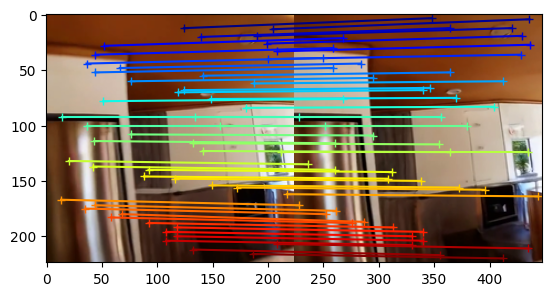

In [40]:
# visualize a few matches
import numpy as np
import torch
import torchvision.transforms.functional
from matplotlib import pyplot as pl

n_viz = 50
num_matches = matches_im0.shape[0]
match_idx_to_viz = np.round(np.linspace(0, num_matches - 1, n_viz)).astype(int)
viz_matches_im0, viz_matches_im1 = (
    matches_im0[match_idx_to_viz],
    matches_im1[match_idx_to_viz],
)


viz_imgs = [scene_state.sparse_ga.imgs[idx1], scene_state.sparse_ga.imgs[idx2]]

H0, W0, H1, W1 = *viz_imgs[0].shape[:2], *viz_imgs[1].shape[:2]
img0 = np.pad(
    viz_imgs[0],
    ((0, max(H1 - H0, 0)), (0, 0), (0, 0)),
    "constant",
    constant_values=0,
)
img1 = np.pad(
    viz_imgs[1],
    ((0, max(H0 - H1, 0)), (0, 0), (0, 0)),
    "constant",
    constant_values=0,
)
img = np.concatenate((img0, img1), axis=1)
pl.figure()
pl.imshow(img)
cmap = pl.get_cmap("jet")
for i in range(n_viz):
    (x0, y0), (x1, y1) = viz_matches_im0[i].T, viz_matches_im1[i].T
    pl.plot(
        [x0, x1 + W0],
        [y0, y1],
        "-+",
        color=cmap(i / (n_viz - 1)),
        scalex=False,
        scaley=False,
    )
pl.show()

In [41]:
pts_1 = scene_state.sparse_ga.get_sparse_pts3d()[idx1]
pts_2 = scene_state.sparse_ga.get_sparse_pts3d()[idx2]

print(pts_1.shape, xy1.shape)
print(pts_2.shape, xy2.shape)

torch.Size([41799, 3]) torch.Size([2289, 2])
torch.Size([41416, 3]) torch.Size([2289, 2])


In [42]:
print(scene_state.sparse_ga.get_dense_pts3d()[1][0].shape)
print(224 ** 2)

torch.Size([50176])
50176


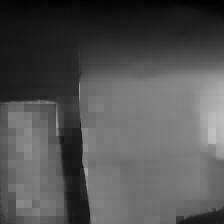

In [43]:
depth_1 = scene_state.sparse_ga.get_dense_pts3d()[1][idx1].reshape(224, 224)
Image.fromarray((((depth_1 - depth_1.min()) / depth_1.max()) * 255).cpu().numpy().astype(np.uint8))

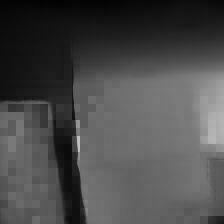

In [44]:
depth_2 = scene_state.sparse_ga.get_dense_pts3d()[1][idx2].reshape(224, 224)
Image.fromarray((((depth_2 - depth_2.min()) / depth_2.max()) * 255).cpu().numpy().astype(np.uint8))

In [45]:
im_1_points = scene_state.sparse_ga.get_dense_pts3d()[0][idx1].reshape(224, 224, 3)
im_2_points = scene_state.sparse_ga.get_dense_pts3d()[0][idx2].reshape(224, 224, 3)

# Using the keypoints, get the corresponding points in each image
# This seems to be the correct ordering (makes sense as matches will be row, col (y, x) and points will be (x,y)) 
im_1_keypoint_cloud = im_1_points[matches_im0[:,1],matches_im0[:,0]]
im_2_keypoint_cloud = im_2_points[matches_im1[:,1],matches_im1[:,0]]

In [46]:
print(im_1_keypoint_cloud)
print()
print(im_2_keypoint_cloud)

tensor([[-2.5574, -2.9221,  0.2423],
        [-2.5243, -2.9380,  0.2135],
        [-2.5243, -2.9380,  0.2135],
        ...,
        [-2.9450, -1.3809, -1.7379],
        [-2.9067, -2.1815, -1.3472],
        [-2.8141, -1.6848, -1.6731]], device='cuda:0')

tensor([[-2.5580, -2.9109,  0.2437],
        [-2.5100, -2.8908,  0.2235],
        [-2.5049, -2.8893,  0.2211],
        ...,
        [-2.9395, -1.3724, -1.7335],
        [-2.8663, -1.4726, -1.7328],
        [-2.7826, -1.3878, -1.8412]], device='cuda:0')


In [47]:
torch.nn.functional.mse_loss(im_1_keypoint_cloud, im_2_keypoint_cloud).item()

0.008997318334877491

In [48]:
# What is the average distance between the two point clouds?
distances = torch.linalg.norm(im_1_keypoint_cloud - im_2_keypoint_cloud, dim=1, ord=2)
print(f"Mean: {distances.mean().item()}")
print(f"Std: {distances.std().item()}")
print(f"Max: {distances.max().item()}")
print(f"Min: {distances.min().item()}")

Mean: 0.08461933583021164
Std: 0.14085747301578522
Max: 2.060807704925537
Min: 0.0003899117873515934


In [49]:
# Show both point clouds

cloud_1 = trimesh.points.PointCloud(im_1_keypoint_cloud.cpu().numpy(), colors=np.repeat(np.array([[0, 0, 255]], dtype=np.uint8),im_1_keypoint_cloud.shape[0], axis=0))
cloud_2 = trimesh.points.PointCloud(im_2_keypoint_cloud.cpu().numpy(), colors=np.repeat(np.array([[255, 0, 0]], dtype=np.uint8),im_2_keypoint_cloud.shape[0], axis=0))


In [50]:
import open3d as o3d
import numpy as np

pcd1 = o3d.geometry.PointCloud()
pcd1.points = o3d.utility.Vector3dVector(cloud_1)
pcd1.paint_uniform_color([0, 0, 1])  # Blue

pcd2 = o3d.geometry.PointCloud()
pcd2.points = o3d.utility.Vector3dVector(cloud_2)
pcd2.paint_uniform_color([1, 0, 0])  # Red


# o3d.visualization.draw_geometries([pcd1, pcd2])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


PointCloud with 2132 points.

In [51]:
np.array([[0, 255, 255]], dtype=np.uint8).shape

(1, 3)

In [52]:
im_1_keypoint_cloud.shape[0]

2132

## Processing

In [53]:
def align_images(video_path, model, scene_graph="swin-1-noncyclic", device="cuda", img_freq=1, max_n_frames=np.inf, outdir="./outputs"):
    imgs, filelist = load_video_as_frames(video_path, load_frequency=img_freq, max_n_frames=max_n_frames)
    
    pairs = make_pairs(imgs, scene_graph=scene_graph, prefilter=None, symmetrize=True, sim_mat=None)
    
    scene = sparse_global_alignment(filelist, pairs, outdir, model, device=device)
    
    return scene
        

In [54]:
def get_matches(sparse_ga, idx1, idx2, outdir="./outputs"):
    img1_fname, img2_fname = sparse_ga.img_paths[idx1], sparse_ga.img_paths[idx2]
    img_1_hash, img_2_hash = hash_md5(img1_fname), hash_md5(img2_fname)
    img_1_shape, img_2_shape = sparse_ga.imgs[idx1].shape[:2], sparse_ga.imgs[idx2].shape[:2]
    
    corres_conf_fwd = os.path.join(outdir, f"corres_conf=desc_conf_subsample=8/{img_1_hash}-{img_2_hash}.pth")
    score, (xy1, xy2, confs) = torch.load(corres_conf_fwd)
    
    H0, W0 = img_1_shape
    H1, W1 = img_2_shape
    
    valid_matches_im0 = (
        (xy1[:, 0] >= 3)
        & (xy1[:, 0] < int(W0) - 3)
        & (xy1[:, 1] >= 3)
        & (xy1[:, 1] < int(H0) - 3)
    )

    valid_matches_im1 = (
        (xy2[:, 0] >= 3)
        & (xy2[:, 0] < int(W1) - 3)
        & (xy2[:, 1] >= 3)
        & (xy2[:, 1] < int(H1) - 3)
    )

    valid_matches = valid_matches_im0 & valid_matches_im1
    matches_im0, matches_im1 = xy1[valid_matches], xy2[valid_matches]
    confs = confs[valid_matches]

    matches_im0 = matches_im0.cpu().numpy()
    matches_im1 = matches_im1.cpu().numpy()
    confs = confs.cpu().numpy()
    
    return matches_im0, matches_im1, confs

In [55]:
def get_matches_clouds(sparse_ga, idx1, idx2, dense_points=None, outdir="./outputs"):
    matches_im0, matches_im1, _ = get_matches(sparse_ga, idx1, idx2, outdir=outdir)
    
    if dense_points is None:
        dense_points = sparse_ga.get_dense_pts3d()
        
    im_1_points = dense_points[0][idx1].reshape(224, 224, 3)
    im_2_points = dense_points[0][idx2].reshape(224, 224, 3)

    # Using the keypoints, get the corresponding points in each image
    # This seems to be the correct ordering (makes sense as matches will be row, col (y, x) and points will be (x,y)) 
    im_1_keypoint_cloud = im_1_points[matches_im0[:,1],matches_im0[:,0]]
    im_2_keypoint_cloud = im_2_points[matches_im1[:,1],matches_im1[:,0]]
    
    return im_1_keypoint_cloud, im_2_keypoint_cloud

def get_match_cloud_metrics(im_1_keypoint_cloud, im_2_keypoint_cloud):
    distances = torch.linalg.norm(im_1_keypoint_cloud - im_2_keypoint_cloud, dim=1, ord=2)
    
    mean = distances.mean().item()
    std = distances.std().item()
    max = distances.max().item()
    min = distances.min().item()
    median = distances.median().item()
    
    total_dist = distances.sum().item()
    n_points = distances.shape[0]
    
    mse = torch.nn.functional.mse_loss(im_1_keypoint_cloud, im_2_keypoint_cloud).item()
    
    output = {
        "mean": mean,
        "std": std,
        "max": max,
        "min": min,
        "median": median,
        "total_dist": total_dist,
        "n_points": n_points,
        "mse": mse,
    }
    
    return output

In [ ]:
from tqdm.notebook import tqdm

def windowed_align(sparse_ga, window_size=1, outdir="./outputs"):
    
    n_frames = len(sparse_ga.img_paths)
    assert window_size > 0
    
    dense_points = sparse_ga.get_dense_pts3d()
    
    # For this we will only consider forward matches. This could be done with reverse matches too,
    # but I think they should be the same? So it would be a waste of time.
    mean_distances = []
    metrics_all = []
    for i in tqdm(range(n_frames-1)):
        frame_mean_distances = []
        frame_metrics = []
        for j in tqdm(range(i+1, min(i+window_size+1, n_frames)), position=1, leave=False):
            im_1_keypoint_cloud, im_2_keypoint_cloud = get_matches_clouds(sparse_ga, i, j, dense_points=dense_points, outdir=outdir)
            if im_1_keypoint_cloud.shape[0] == 0 or im_2_keypoint_cloud.shape[0] == 0:
                frame_mean_distances.append(None)
                continue
            metrics = get_match_cloud_metrics(im_1_keypoint_cloud, im_2_keypoint_cloud)
            
            frame_mean_distances.append(metrics["mean"])
            frame_metrics.append(metrics)
        
        mean_distances.append(frame_mean_distances)
        metrics_all.append(frame_metrics)
    
    return mean_distances, metrics_all
    
    

In [57]:
vid_real = "/scratch/toskov/data/scannetpp_working/0a76e06478/iphone/rgb.mp4"
vid_gen = "/home/toskov/gen_test_vid.mp4"

window_size = 10

scene_graph = f"swin-{window_size}-noncyclic"
device = "cuda"

outdir_real = "./outputs_real"
outdir_gen = "./outputs_gen"

In [58]:
assert outdir_real != outdir_gen, "Output directories must be different"

if os.path.exists(outdir_real):
    shutil.rmtree(outdir_real)
os.makedirs(outdir_real, exist_ok=True)

print("Processing real")
scene_real = align_images(vid_real, model, scene_graph=scene_graph, device=device, img_freq=15, max_n_frames=80, outdir=outdir_real)

if os.path.exists(outdir_gen):
    shutil.rmtree(outdir_gen)
os.makedirs(outdir_gen, exist_ok=True)

print("Processing generated")
scene_gen = align_images(vid_gen, model, scene_graph=scene_graph, device=device, img_freq=2, max_n_frames=80, outdir=outdir_gen)


Processing real


  0%|          | 0/1490 [00:00<?, ?it/s]/home/toskov/perspective-analysis-of-generated-images/mast3r/mast3r/cloud_opt/sparse_ga.py:620: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
 50%|█████     | 745/1490 [01:58<02:04,  5.97it/s]/home/toskov/perspective-analysis-of-generated-images/mast3r/mast3r/cloud_opt/sparse_ga.py:577: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be

init focals = [228.15933 230.79982 233.37437 232.66591 237.41824 237.7002  238.4092
 230.62546 230.11827 228.4611  229.78416 232.97887 231.16647 226.48051
 228.30408 228.60135 226.94244 227.78027 235.17009 239.65967 243.76877
 252.95636 249.47879 246.22685 246.12741 237.3663  251.41295 251.35432
 243.37155 235.26318 236.86868 232.16908 226.88522 223.66547 221.3962
 224.06941 227.78506 225.28925 225.27765 227.21986 225.53613 225.64607
 226.48332 227.60309 227.51466 225.46378 219.44495 221.85782 222.21367
 225.32256 225.03447 224.57236 234.34499 232.81706 226.7417  225.65619
 226.86108 230.43098 237.34152 244.9851  245.50478 247.07225 248.22833
 238.55032 239.68231 235.93555 245.4768  228.84622 216.09344 217.3168
 215.8887  217.65054 217.30873 221.33656 220.53853 218.86809 226.99646
 226.99861 229.18549 224.49376]


100%|██████████| 300/300 [01:21<00:00,  3.67it/s, lr=0.0000, loss=0.040]


>> final loss = 0.03988221660256386


100%|██████████| 300/300 [01:58<00:00,  2.52it/s, lr=0.0000, loss=0.378]


>> final loss = 0.3779490292072296
Final focals = [219.91957 220.3199  222.03645 222.90527 223.76288 225.28839 225.5883
 226.10728 226.9958  227.35751 227.24771 226.87666 226.19247 225.55206
 224.17725 223.85881 224.70035 226.7179  229.13655 230.65393 232.68477
 234.52808 235.61456 235.16179 232.77876 231.45424 230.78893 227.32043
 223.28973 220.2241  218.33481 217.69185 218.15092 216.68768 217.72827
 218.34564 219.2252  219.4259  219.13188 220.77916 221.2819  222.38908
 222.90283 223.13072 222.95769 222.79869 223.21895 223.26385 224.93126
 224.00766 220.68097 217.52013 221.3335  226.6162  225.68675 229.26616
 229.40547 229.7112  231.11302 231.2893  233.73776 238.69267 238.41159
 238.16696 235.00105 230.9045  230.37892 220.15366 214.15564 212.04039
 212.25769 212.87851 213.9161  214.07294 217.87202 220.43918 227.14252
 223.68372 223.40645 224.2089 ]
Processing generated


100%|██████████| 80/80 [00:05<00:00, 15.94it/s]


init focals = [237.8324  231.64427 229.80313 237.20529 228.2971  228.33174 227.28099
 220.38672 237.8366  236.12723 232.5336  243.63757 239.70116 233.30804
 249.88072 238.81744 250.68976 262.91086 255.82246 265.78186 242.4157
 253.27536 248.42784 265.55472 260.3252  256.8923  257.89456 255.16544
 239.91193 226.22073 235.06828 226.7964  224.38654 221.03787 223.66762
 231.02544 231.04526 224.13159 234.43594 232.21791 235.78732 238.60095
 232.87825 229.66927 238.19807 248.17827 240.52255 248.80412 254.41423
 289.84473 274.69388 274.02118 283.39563 256.9913  245.54657 276.61295
 244.94713 249.21458 291.59015 328.37402 329.4815  316.73053 337.18332
 315.88214 383.35126 363.9082  362.81714 468.5686  440.21222 376.62238
 342.692   395.65787 484.77982 457.72885 540.72565 511.9912  527.5038
 456.10852 339.67203 365.0633 ]


100%|██████████| 300/300 [02:13<00:00,  2.26it/s, lr=0.0000, loss=0.237]


>> final loss = 0.23710377514362335


100%|██████████| 300/300 [03:05<00:00,  1.62it/s, lr=0.0000, loss=0.486]

>> final loss = 0.4861879348754883
Final focals = [251.8987  248.81848 245.46077 245.5844  245.94453 244.06851 244.34286
 243.62886 243.01334 243.23535 243.56706 243.85132 245.28456 248.65492
 246.73871 246.64436 247.20317 249.73897 249.8047  251.70802 251.8336
 251.0467  251.00769 247.1129  244.8933  242.21278 241.86806 242.5984
 242.15689 240.63187 238.79945 238.97147 240.17702 241.03404 242.42633
 241.64418 240.67514 240.24367 237.92563 236.38745 235.87076 234.66768
 236.18825 238.55692 241.63405 242.09688 242.99214 243.45142 245.58662
 247.35445 245.83994 249.30458 247.75047 249.2223  249.45119 247.1024
 247.41496 254.35469 258.90823 255.78854 266.51184 273.53687 279.7212
 282.59204 287.06647 397.29337 425.1559  665.4525  586.59875 363.0861
 335.85385 398.99786 514.97125 510.55405 555.8074  577.03094 602.0701
 622.66144 470.6877  501.69952]


Aligning real


/home/toskov/perspective-analysis-of-generated-images/mast3r/mast3r/cloud_opt/sparse_ga.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  (canon, canon2, conf), focal = t

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_6257/1183371727.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  score, (xy1, xy2, confs) = torch.load(corres_conf_fwd)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Aligning generated


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_6257/378266343.py:21: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /opt/conda/conda-bld/pytorch_1729647429097/work/aten/src/ATen/native/ReduceOps.cpp:1823.)
  std = distances.std().item()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

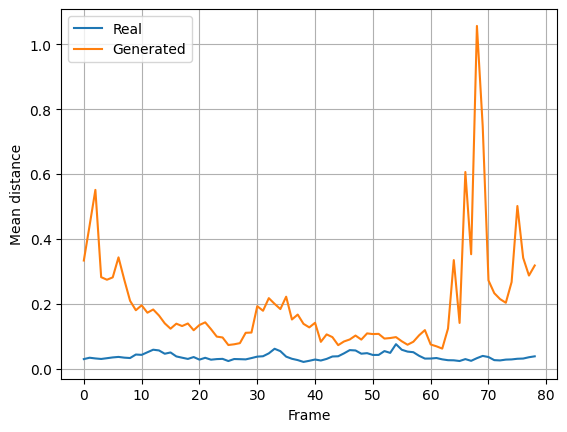

In [ ]:
print("Aligning real")
mean_dists_real, _ = windowed_align(scene_real, window_size=1, outdir=outdir_real)
mean_array_real = np.array([np.mean(x) for x in mean_dists_real])

print("Aligning generated")
mean_distances_gen, _ = windowed_align(scene_gen, window_size=1, outdir=outdir_gen)
mean_array_gen = np.array([np.mean(x) for x in mean_distances_gen])

# plot mean distance per frame through time
pl.plot(mean_array_real)
pl.plot(mean_array_gen)
pl.legend(["Real", "Generated"])
pl.xlabel("Frame")
pl.ylabel("Mean distance")
pl.grid()

Aligning real


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_6257/1183371727.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  score, (xy1, xy2, confs) = torch.load(corres_conf_fwd)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Aligning generated


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_6257/378266343.py:21: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /opt/conda/conda-bld/pytorch_1729647429097/work/aten/src/ATen/native/ReduceOps.cpp:1823.)
  std = distances.std().item()


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

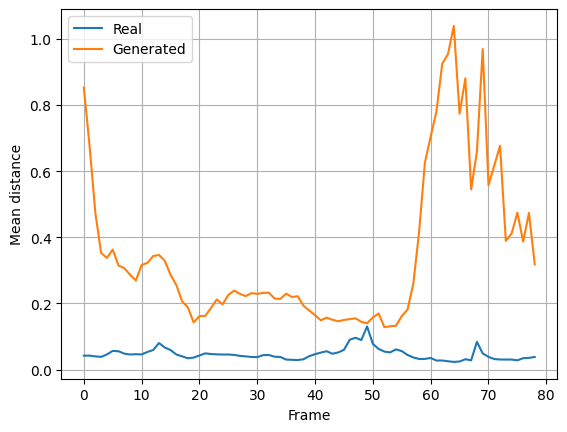

In [ ]:
print("Aligning real")
mean_dists_real, _ = windowed_align(scene_real, window_size=window_size, outdir=outdir_real)
mean_array_real = np.array([np.mean(np.array(x)[np.array(x) != None]) for x in mean_dists_real])

print("Aligning generated")
mean_distances_gen, _ = windowed_align(scene_gen, window_size=window_size, outdir=outdir_gen)
mean_array_gen = np.array([np.mean(np.array(x)[np.array(x) != None]) for x in mean_distances_gen])

# plot mean distance per frame through time
pl.plot(mean_array_real)
pl.plot(mean_array_gen)
pl.legend(["Real", "Generated"])
pl.xlabel("Frame")
pl.ylabel("Mean distance")
pl.grid()

In [ ]:
scannet_data_dir = "/scratch/toskov/data/scannetpp_link/data/"

scannet_keys = os.listdir(scannet_data_dir)

vid_suffix = "iphone/rgb.mp4"

output_root = "/scratch/toskov/data/geom_align_outputs/"
os.makedirs(output_root, exist_ok=True)

# temp_output_dir = "/scratch/toskov/data/geom_align_outputs_temp/"


window_size = 10
scene_graph = f"swin-{window_size}-noncyclic"
device = "cuda"

img_freq = 15 # Scannet++ is 60fps so this is 4fps
max_n_frames = 80 # This is 20 seconds of video then

for key in scannet_keys:
    vid_path = os.path.join(scannet_data_dir, key, vid_suffix)
    if not os.path.exists(vid_path):
        print(f"Video {vid_path} does not exist")
        continue
    
    print(f"Processing {key}")
    
    outdir = os.path.join(output_root, key)
    if os.path.exists(outdir):
        shutil.rmtree(outdir)
    
    # if os.path.exists(temp_output_dir):
    #     shutil.rmtree(temp_output_dir)
    
    scene_real = align_images(vid_path, model, scene_graph=scene_graph, device=device, img_freq=img_freq, max_n_frames=max_n_frames, outdir=outdir)

    mean_dists_real, metrics = windowed_align(scene_real, window_size=window_size, outdir=outdir)
    
    mean_array_real = np.array([np.mean(np.array(x)[np.array(x) != None]) for x in mean_dists_real])

    # plot mean distance per frame through time
    pl.plot(mean_array_real)
    pl.legend(["Real", "Generated"])
    pl.xlabel("Frame")
    pl.ylabel("Mean distance")
    pl.grid()
    pl.savefig(os.path.join(outdir, "mean_distance.png"))
    
    # Dump metrics
    metrics_path = os.path.join(outdir, "metrics.pth")
    torch.save(metrics, metrics_path)
    print(f"Saved metrics to {metrics_path}")
    

    
    
    

Processing 56a0ec536c


  0%|          | 0/1490 [00:00<?, ?it/s]/home/toskov/perspective-analysis-of-generated-images/mast3r/mast3r/cloud_opt/sparse_ga.py:620: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
 25%|██▌       | 377/1490 [01:21<03:44,  4.95it/s]